# Airbnb New User Booking
by - Brittnie Yi, Vaibhav Gupta

## Importing Libraries

In [44]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ndcg_score
import tensorflow as tf 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Path To Data

In [2]:
train = pd.read_csv('train_users_2.csv')
test = pd.read_csv('test_users.csv')

In [3]:
train.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [4]:
test.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome


**Before we do anything else, we will combine these dataset for some preprocessing steps**

1. Look at the length of each dataset
2. Concat the dataset by row

In [5]:
print("Length of Train Dataset:", len(train))
print("Length of Test Dataset:", len(test))

Length of Train Dataset: 213451
Length of Test Dataset: 62096


In [6]:
full_data = pd.concat([train, test], axis = 0)
full_data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## Exploratory Data Analysis

Lets take a look at our feature variables

<AxesSubplot:>

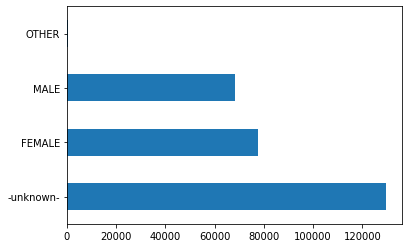

In [7]:
full_data.gender.value_counts().plot.barh()

**There are a lot of unknown genders in this dataset**

<AxesSubplot:>

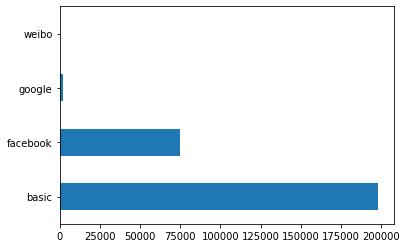

In [8]:
full_data.signup_method.value_counts().plot.barh()

**Most of the people have used the basic signup method**

<AxesSubplot:>

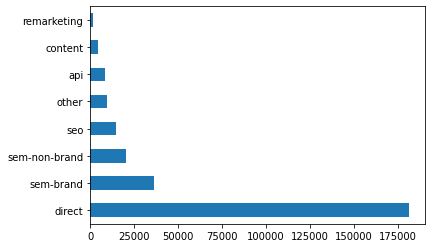

In [9]:
full_data.affiliate_channel.value_counts().plot.barh()

<AxesSubplot:>

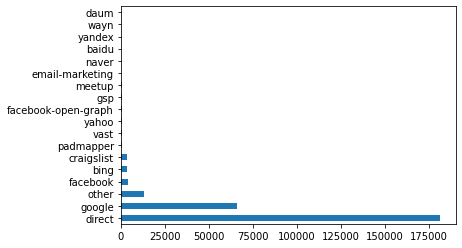

In [10]:
full_data.affiliate_provider.value_counts().plot.barh()

<AxesSubplot:>

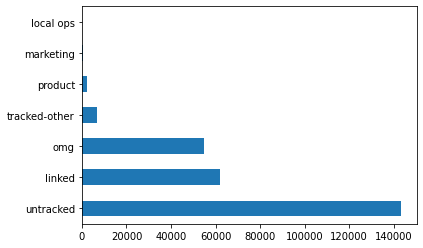

In [11]:
full_data.first_affiliate_tracked.value_counts().plot.barh()

<AxesSubplot:>

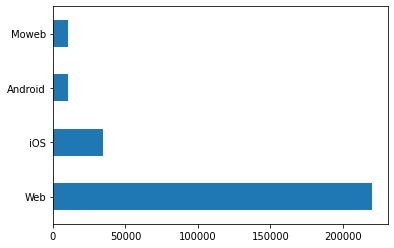

In [12]:
full_data.signup_app.value_counts().plot.barh()

<AxesSubplot:>

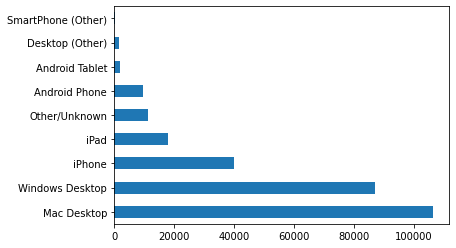

In [13]:
full_data.first_device_type.value_counts().plot.barh()

<AxesSubplot:>

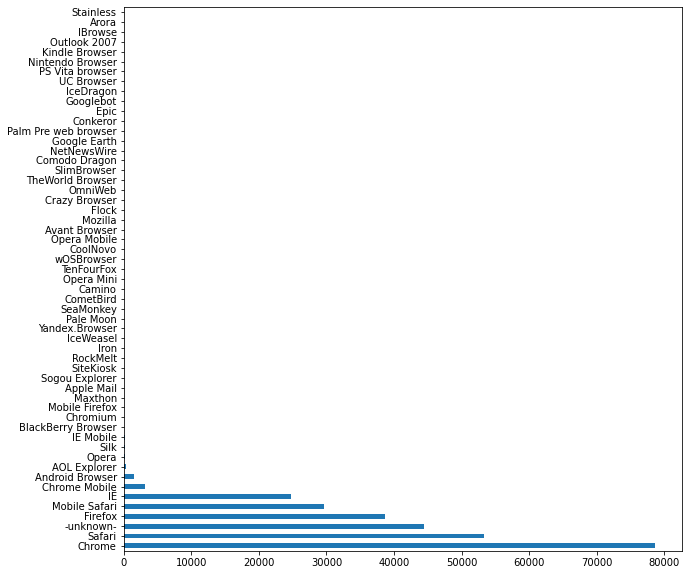

In [14]:
plt.figure(figsize=(10,10))
full_data.first_browser.value_counts().plot.barh()

<AxesSubplot:>

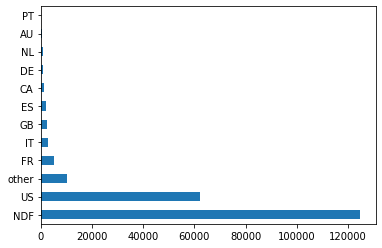

In [15]:
full_data.country_destination.value_counts().plot.barh()

## Preprocessing

1. Dropping date and timestamp columns from train and test data
2. Check for missing values and columns types

In [16]:
full_data = full_data.drop(["id",'date_account_created',"timestamp_first_active",'date_first_booking'], axis = 1)


print("Number of Rows, Number of Columns:", full_data.shape)
full_data.head(3)


Number of Rows, Number of Columns: (275547, 12)


,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [17]:
# Checking for missing values

full_data.isna().sum()

gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
country_destination         62096
dtype: int64

### Lets plot the distribution for the age columns

/home/vbgupta/Desktop/School/ds310/school_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


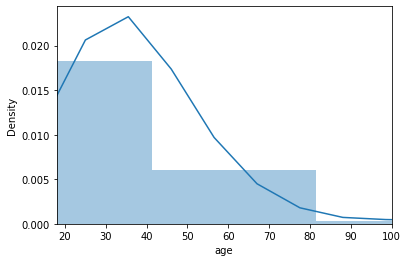

In [18]:
sns.distplot(full_data.age.dropna())
plt.xlim(18,100);

**1. There are a lot of missing records of age**

**1.a. Since the majority of people have age between 25-35, we can randomly assign these ages to the missing records using Forward Fill**

**2. Drop First_affiliate_tracked**

In [19]:
# Fill in missing values for Age
full_data['age'] = full_data['age'].fillna(method = 'ffill')
full_data['age'] = full_data['age'].fillna(full_data['age'].median())

In [20]:
# Check missing values
full_data.isna().sum()

gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     6085
signup_app                     0
first_device_type              0
first_browser                  0
country_destination        62096
dtype: int64

In [21]:
# Drop the first_affiliate_tracked
full_data.drop('first_affiliate_tracked', axis = 1, inplace= True)

In [22]:
# Convert categorical variable's type to category

full_data[['gender', 'signup_method', 'language', 'affiliate_channel','affiliate_provider', 'signup_app', 'first_device_type',
'first_browser', 'country_destination']] = full_data[['gender', 'signup_method', 'language', 'affiliate_channel','affiliate_provider', 'signup_app', 'first_device_type',
'first_browser', 'country_destination']].astype('category')
full_data.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination
0,-unknown-,33.0,facebook,0,en,direct,direct,Web,Mac Desktop,Chrome,NDF
1,MALE,38.0,facebook,0,en,seo,google,Web,Mac Desktop,Chrome,NDF
2,FEMALE,56.0,basic,3,en,direct,direct,Web,Windows Desktop,IE,US
3,FEMALE,42.0,facebook,0,en,direct,direct,Web,Mac Desktop,Firefox,other
4,-unknown-,41.0,basic,0,en,direct,direct,Web,Mac Desktop,Chrome,US


### Encoding Categorical Columns using .cat_codes

1. X_train
2. test
3. y

In [23]:
full_data['gender'] = full_data['gender'].cat.codes 
full_data['signup_method'] = full_data['signup_method'].cat.codes
full_data['language'] = full_data['language'].cat.codes
full_data['affiliate_channel'] = full_data['affiliate_channel'].cat.codes
full_data['affiliate_provider'] = full_data['affiliate_provider'].cat.codes
full_data['signup_app'] = full_data['signup_app'].cat.codes
full_data['first_device_type'] = full_data['first_device_type'].cat.codes
full_data['first_browser'] = full_data['first_browser'].cat.codes
full_data['country_destination_encoded'] = full_data['country_destination'].cat.codes


In [24]:
out_data = full_data[['country_destination_encoded', 'country_destination']]
out_data.to_csv('encoded.csv')

### Separate the data into train, y, and test

In [25]:
X_train = full_data.iloc[:213450, :]
X_test = full_data.iloc[213451:, :]
X_test = X_test.drop(['country_destination', 'country_destination_encoded'], axis = 1)

X_train.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,country_destination_encoded
0,0,33.0,1,0,6,2,4,2,3,8,NDF,7
1,2,38.0,1,0,6,7,8,2,3,8,NDF,7
2,1,56.0,0,3,6,2,4,2,6,22,US,10
3,1,42.0,1,0,6,2,4,2,3,17,other,11
4,0,41.0,0,0,6,2,4,2,3,8,US,10


In [26]:
X_test.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser
0,1,35.0,1,0,6,2,4,1,8,30
1,0,35.0,0,0,6,2,4,1,8,30
2,0,35.0,0,0,6,2,4,2,6,8
3,0,35.0,0,0,6,2,4,2,6,22
4,0,35.0,0,0,6,2,4,2,3,43


In [27]:
y = X_train['country_destination_encoded']
X_train = X_train.drop(['country_destination', 'country_destination_encoded'], axis = 1)
le = LabelEncoder()
y = le.fit_transform(y)

## Model

1. DecisionTreeClassifier
2. RandomForestClassifier
3. Sequential Model DL

In [28]:
dtc = DecisionTreeClassifier(random_state=44)
dtc.fit(X_train, y)
y_preds_dtc = dtc.predict_proba(X_test)
y_preds_dtc

array([[0.        , 0.        , 0.        , ..., 0.        , 0.25      ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01056338, 0.        , ..., 0.        , 0.24647887,
        0.04577465],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.01538462, 0.        , ..., 0.        , 0.21538462,
        0.01538462],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [29]:
predictions = np.argpartition(-y_preds_dtc, 4, axis = 1)[:,0:5:]
predictions # ndcg score 0.68763

array([[ 7, 10,  9,  5,  8],
       [ 9,  7, 10,  5,  8],
       [ 7, 11, 10,  5,  4],
       ...,
       [ 9, 10,  7,  5,  8],
       [ 4,  5, 10,  7, 11],
       [ 9,  7, 10,  5,  8]])

In [30]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 44)
rfc.fit(X_train, y)
y_preds_rfc = dtc.predict_proba(X_test)
y_preds_rfc
predictions = np.argpartition(-y_preds_dtc, 4, axis = 1)[:,0:5:]
predictions # ndcg score 0.68763

array([[ 7, 10,  9,  5,  8],
       [ 9,  7, 10,  5,  8],
       [ 7, 11, 10,  5,  4],
       ...,
       [ 9, 10,  7,  5,  8],
       [ 4,  5, 10,  7, 11],
       [ 9,  7, 10,  5,  8]])

In [31]:
xgb = XGBClassifier(random_state = 44)
xgb.fit(X_train, y)
y_preds_xgb = xgb.predict_proba(X_test)
predictions = np.argpartition(-y_preds_xgb, 4, axis = 1)[:,0:5:]
predictions # ndcg 0.73611

/home/vbgupta/Desktop/School/ds310/school_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[21:01:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/home/vbgupta/Desktop/School/ds310/school_env/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([[ 7, 10,  4, 11,  3],
       [11, 10,  7,  4,  1],
       [ 7, 10, 11,  4,  6],
       ...,
       [ 7,  5,  2, 10, 11],
       [ 7, 10, 11,  4,  6],
       [ 4, 10, 11,  7,  6]])

## Creating the Submission File

In [34]:
submission = pd.DataFrame(data=predictions, index=test['id'])

submission = pd.melt(
    submission.reset_index(), 
    id_vars=['id'], 
    value_vars=[0, 1, 2, 3, 4],
    value_name='country'
)
submission = submission.drop('variable', axis = 1)

# Creating a dict to map the countries to

dict_countries = { 10: 'US', 4: 'FR', 1: 'CA', 5: 'GB', 3: 'ES', 6: 'IT', 9: 'PT', 8: 'NL', 2: 'DE', 0: 'AU', 7: 'NDF', 11: 'other'
}


submission['country'] =submission['country'].map(dict_countries)

In [35]:
submission.to_csv('submission.csv', index = False)